In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [36]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from IPython.display import display
# Change these variable values to display more dataframe rows or columns
pd.options.display.max_rows = 10
pd.options.display.max_columns = 999

# 1- Top Universities Ranking

To load the data in Python , we started by browsing the network traffic when accessing QS Ranking's web page using Google Chrome's developper tools. We noticed that the displayed data is mainly loaded from JSON files.
Hence we use this [JSON file](https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508247297704) to collect the rankings instead of web scrapping them. 

In [4]:
nb_uni = 200

#JSON file link 
URL ='https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1508247297704'

#Collect the json file from the link above
URL_paste = 'https://www.topuniversities.com'
r = requests.get(URL).json()
nb_uni = 200

# Creating the data frame containing the universities ranking
dataFrame_QS = pd.DataFrame(r['data'][:nb_uni])

The loaded JSON file attributes are listed below but we will use only a subset of them

In [5]:
dataFrame_QS.columns

Index(['cc', 'core_id', 'country', 'guide', 'logo', 'nid', 'rank_display',
       'region', 'score', 'stars', 'title', 'url'],
      dtype='object')

** Web Scrapping Process **<br>
In order to get the student and faculty members statistics of each university, we used the URL attribute attached to each entry in the JSON file. Each URL points to the web page containing information for the concerned university.

After identifying a common HTML pattern in the QS university webpage, we made the following observations:

    - The total number of faculty members is always wrapped in div tags with class name 'total faculty'
    - The number of international faculty members  is always wrapped in div tags with class name 'inter faculty'
    - The total number of international students is always wrapped in div tags with class name 'total inter'
    - The total number of international students is always wrapped in div tags with class name 'total student'
    - The numerical values that we are interested are wrapped inside nested div tags with class name 'number'
    
**Note** : We couldn't get faculty members and students statistics for New York University since the university web page doesn't include them. We instead filled the non-found information entries in the data frame by NaN

        

In [6]:
def numerical_parser(entry):
    '''Function used to fetch the  values that we are interested in from 
    the selected divs and converts them to integers'''
    return int(entry.find('div', class_='number').text.replace('\n','').replace(',','')) if entry != None else None

def get_infos(x):
    '''Function used to web scrap the  statistics of each university'''
    reqs = requests.get('https://www.topuniversities.com/'+ x['url'], stream=True)
    sou = BeautifulSoup(reqs.text,'html.parser')
    ret =  sou.find('div', class_='total faculty')
    x['total_faculty_members'] = numerical_parser(ret)
    ret =  sou.find('div', class_='inter faculty')
    x['international_faculty_members'] = numerical_parser(ret)
    ret =  sou.find('div', class_='total inter')
    x['international_student'] = numerical_parser(ret)
    ret =  sou.find('div', class_='total student')
    x['total_students'] = numerical_parser(ret)
    return x
    

# Creating the columns that will hold the universities informations 
dataFrame_QS['total_students'] = pd.Series()
dataFrame_QS['international_student'] = pd.Series()
dataFrame_QS['total_faculty_members'] = pd.Series()
dataFrame_QS['international_faculty_members'] = pd.Series()

# using get_info function to fill the coluimns defined above
dataFrame_QS = dataFrame_QS.apply(get_infos,axis= 1)

# Selecting the useful columns from the data frame
dataFrame_QS = dataFrame_QS [['rank_display','title','country','region','total_students','international_student','total_faculty_members','international_faculty_members']]

In [8]:
import matplotlib.pyplot as plt

def plot_bar_chart(k,col_name,df,title_part,x_col):
    '''used to plot the bar charts'''
    y = df[col_name][:k]
    x = df[x_col][:k] if x_col != None else df.index[:k]
    y_pos = np.arange(len(x))
    plt.bar(y_pos,y)
    plt.title('Best '+title_part+' in terms of '+ col_name)
    plt.xticks(y_pos,x , rotation = 90)
    plt.xlabel(title_part)
    plt.ylabel(col_name)
    plt.show()

 **Renaming columns and computing the ratios:**

In [9]:
# Renaming the generated data frame columns for Readability purpose
dataFrame_QS.rename(columns={'title':'Name',
                   'region':'Region',
                   'country':'Location',
                   'overall_rank':'Rank',
                   'total_faculty_members':'Total Academic Faculty Staff', 
                   'international_faculty_members':'Intl Academic Faculty Staff', 
                   'rank_display': 'Rank',
                   'total_students': 'Total students', 
                   'international_student':'Intl Students'}, inplace=True)

# Convert the ranks to numerical values
dataFrame_QS['Rank']= dataFrame_QS['Rank'].apply(lambda x : x.replace('=','')).apply(pd.to_numeric)

# compute the Ratio Faculty Members to Students and the Ratio of Intl Students from collected data
dataFrame_QS['Ratio Faculty Members to Students'] = dataFrame_QS['Total Academic Faculty Staff']/dataFrame_QS['Total students']
dataFrame_QS['Ratio of Intl Students'] = dataFrame_QS['Intl Students']/dataFrame_QS['Total students']

**Best universities in term of ratio of faculty members to students:**

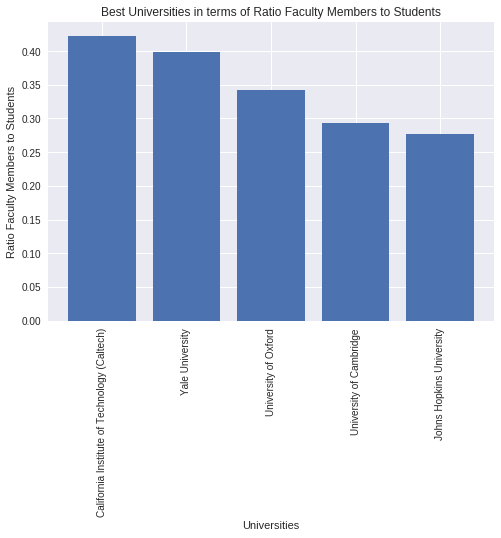

In [10]:
y= dataFrame_QS.sort_values(by='Ratio Faculty Members to Students', ascending=0)
plot_bar_chart(5,'Ratio Faculty Members to Students',y,'Universities','Name')

**Best universities in term of ratio of international students:**

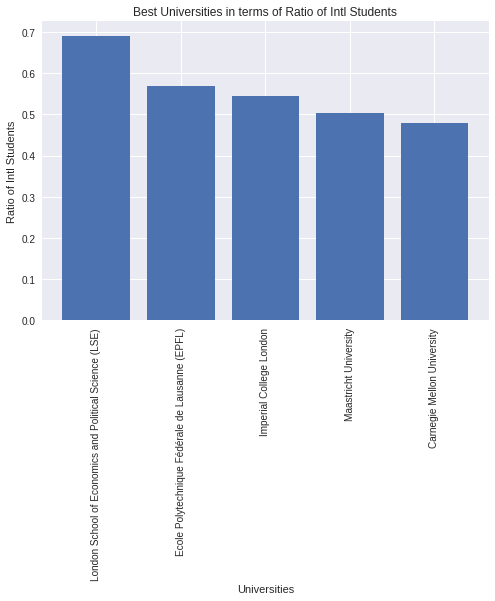

In [11]:
y = dataFrame_QS.sort_values(by='Ratio of Intl Students', ascending=0)
plot_bar_chart(5,'Ratio of Intl Students',y,'Universities','Name')

**Best countries in term of universities' ratio of faculty members to students:** 

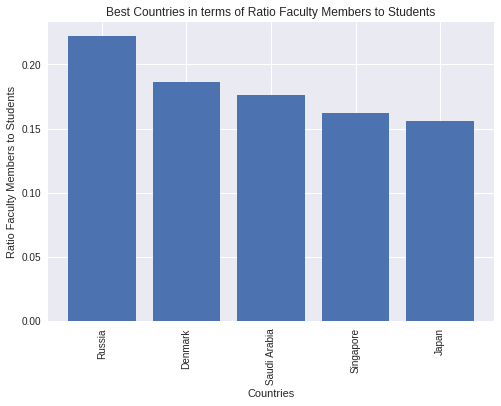

In [12]:
dataFrame_QS_agg = dataFrame_QS.groupby(['Location']).mean()
y = dataFrame_QS_agg.sort_values(by='Ratio Faculty Members to Students', ascending=0)
plot_bar_chart(5,'Ratio Faculty Members to Students',y,'Countries',None)

**Best regions in term of universities' ratio of faculty members to students:** 

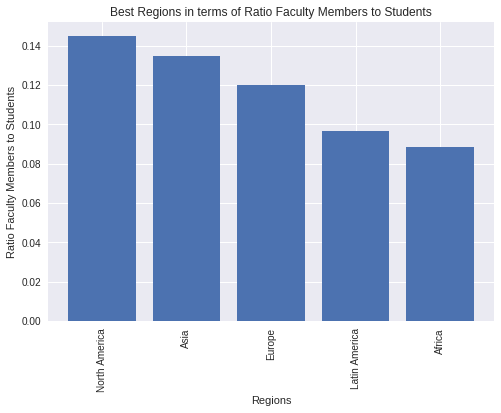

In [13]:
dataFrame_QS_agg = dataFrame_QS.groupby(['Region']).mean()
y = dataFrame_QS_agg.sort_values(by='Ratio Faculty Members to Students', ascending=0)
plot_bar_chart(5,'Ratio Faculty Members to Students',y,'Regions',None)

**Best countries in term universities' of ratio of international students:** 

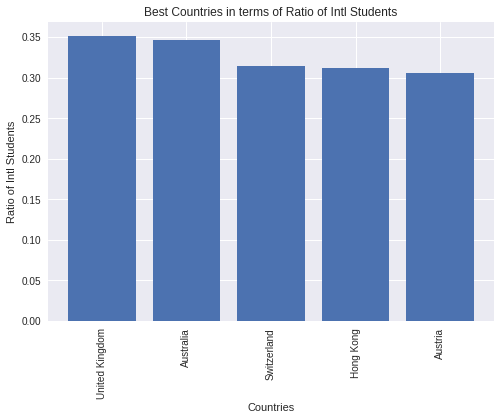

In [14]:
dataFrame_QS_agg = dataFrame_QS.groupby(['Location']).mean()
y = dataFrame_QS_agg.sort_values(by='Ratio of Intl Students', ascending=0)
plot_bar_chart(5,'Ratio of Intl Students',y,'Countries',None)

**Best regions in term of universities' ratio of international students:** 

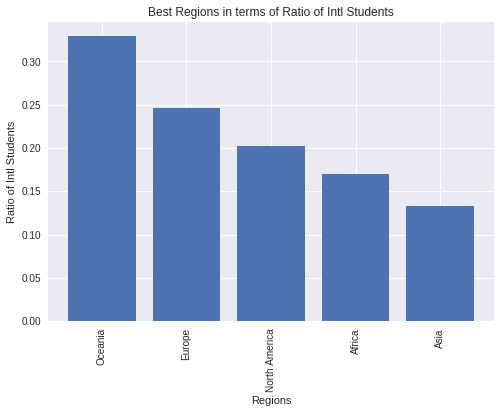

In [15]:
dataFrame_QS_agg = dataFrame_QS.groupby(['Region']).mean()
y = dataFrame_QS_agg.sort_values(by='Ratio of Intl Students', ascending=0)
plot_bar_chart(5,'Ratio of Intl Students',y,'Regions',None)

# 2- Times Higher Education Ranking

By following the same approach as in the first task, we found the following [json file](https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json) from which the data is loaded when opening the web page.
We also noticed that the number of international staff members and the region of each university are not mentionned in this dataset.

**Assumption**: We will assume that *FTE students* express the total number of enrolled students.

For this web site we don't need to scrap the statistics related to each university as they are available in our JSON file.


In [16]:
# Fetch the json file
URL = "https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json"
r = requests.get(URL)

# convert it to a dataframe
dataFrame = pd.DataFrame(r.json()['data'][:200])

The loaded JSON file attributes are listed below but we will only use a subset of them.

In [17]:
dataFrame.columns

Index(['aliases', 'location', 'member_level', 'name', 'nid', 'rank',
       'rank_order', 'record_type', 'scores_citations',
       'scores_citations_rank', 'scores_industry_income',
       'scores_industry_income_rank', 'scores_international_outlook',
       'scores_international_outlook_rank', 'scores_overall',
       'scores_overall_rank', 'scores_research', 'scores_research_rank',
       'scores_teaching', 'scores_teaching_rank', 'stats_female_male_ratio',
       'stats_number_students', 'stats_pc_intl_students',
       'stats_student_staff_ratio', 'subjects_offered', 'url'],
      dtype='object')

The selected columns are :

    - name : University name
    - rank : University rank
    - location : University country
    - stats_number_students : Total number of students in the university
    - stats_pc_intl_students : The rate of international students in the university 
    - stats_student_staff_ratio : The student staff ratio in the university

In [18]:
# select useful columns
selected_col = ['name','rank','location','stats_number_students','stats_pc_intl_students','stats_student_staff_ratio']
dataFrame_THE = dataFrame.loc[:,selected_col]

**Parsing numerical values, reformating values and computing missing values:**

In [19]:
# Parse columns to numerical values and convert them to same format of THE ranking columns
dataFrame_THE['stats_pc_intl_students'] = dataFrame_THE['stats_pc_intl_students'].apply(lambda x: x.strip('%')).astype(float)
dataFrame_THE['stats_number_students']= dataFrame_THE['stats_number_students'].apply(lambda x: x.replace(',','')).astype(int)
dataFrame_THE['stats_pc_intl_students'] = dataFrame_THE['stats_pc_intl_students']/100
dataFrame_THE['stats_student_staff_ratio'] =  1.0/(dataFrame_THE['stats_student_staff_ratio'].astype(float))

# Compute the number of international students and faculty members 
dataFrame_THE['intl_students'] = (dataFrame_THE['stats_number_students']*dataFrame_THE['stats_pc_intl_students']).astype(int)
dataFrame_THE['fac_members'] = (dataFrame_THE['stats_student_staff_ratio']*dataFrame_THE['stats_number_students']).astype(int)

** Column renaming:**

In [20]:
#Rename columns for readability  and consistency (With the previous ranking) purpose
dataFrame_THE.rename(columns={'name':'Name',
                   'location':'Location',
                   'rank':'Rank',
                   'fac_members':'Total Academic Faculty Staff', 
                   'stats_number_students': 'Total students', 
                   'intl_students':'Intl Students',
                   'stats_student_staff_ratio':'Ratio Faculty Members to Students',
                    'stats_pc_intl_students' :'Ratio of Intl Students'      }, inplace=True)
dataFrame_THE

,Name,Rank,Location,Total students,Ratio of Intl Students,Ratio Faculty Members to Students,Intl Students,Total Academic Faculty Staff
0,University of Oxford,1,United Kingdom,20409,0.38,0.089286,7755,1822
1,University of Cambridge,2,United Kingdom,18389,0.35,0.091743,6436,1687
2,California Institute of Technology,=3,United States,2209,0.27,0.153846,596,339
3,Stanford University,=3,United States,15845,0.22,0.133333,3485,2112
4,Massachusetts Institute of Technology,5,United States,11177,0.34,0.114943,3800,1284
...,...,...,...,...,...,...,...,...
195,Paris-Sorbonne University – Paris 4,196,France,22042,0.15,0.033113,3306,729
196,"Royal Holloway, University of London",197,United Kingdom,8931,0.40,0.064935,3572,579
197,"University of California, Riverside",=198,United States,20740,0.14,0.048309,2903,1001
198,University of Gothenburg,=198,Sweden,18378,0.13,0.100000,2389,1837


**Best universities in term of ratio of faculty members to students:**

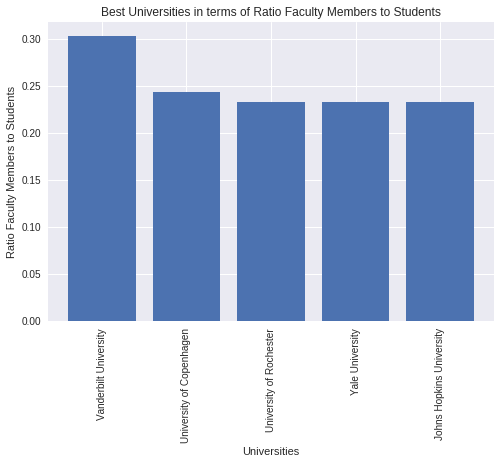

In [21]:
y = dataFrame_THE.sort_values(['Ratio Faculty Members to Students'], ascending=[0])
plot_bar_chart(5,'Ratio Faculty Members to Students',y,'Universities','Name')

**Best universities in term of ratio of international students:**

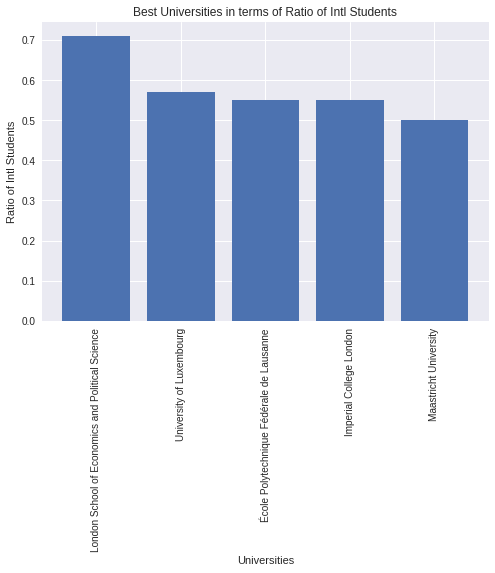

In [22]:
y = dataFrame_THE.sort_values(['Ratio of Intl Students'], ascending=[0])
plot_bar_chart(5,'Ratio of Intl Students',y,'Universities','Name')

**Best countries in term of universities' ratio of faculty members to students:** 

In [23]:
# convert the rank column elements to float type
dataFrame_THE['Rank'] = dataFrame_THE['Rank'].apply(lambda x: x.replace('=','') if type(x) == str else x).apply(pd.to_numeric)

# aggregate by location using the mean operator
groupped = dataFrame_THE.groupby('Location').mean()

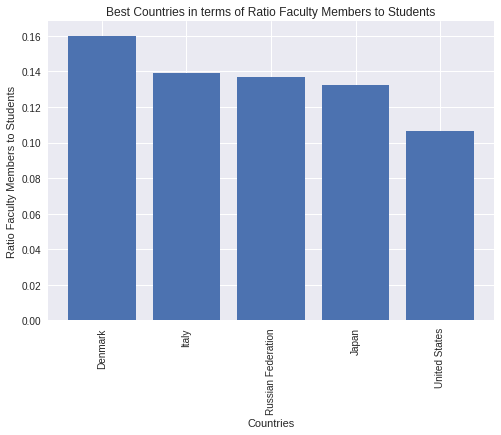

In [24]:
# Rank the aggrerated values by staff:student ratio
y = groupped.sort_values(['Ratio Faculty Members to Students'], ascending=[0])
plot_bar_chart(5,'Ratio Faculty Members to Students',y,'Countries',None)

**Best countries in term of universities' ratio of international students:** 

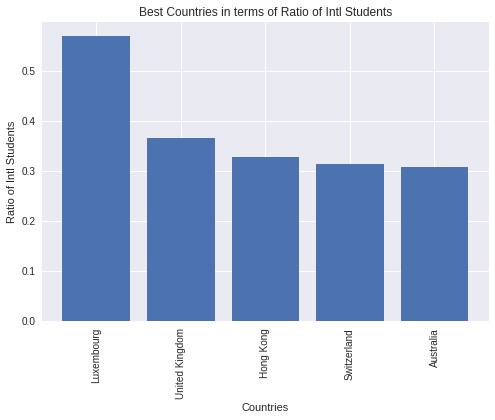

In [25]:
# Rank the aggrerated values by ratio of international student
y= groupped.sort_values(['Ratio of Intl Students'], ascending=[0])
plot_bar_chart(5,'Ratio of Intl Students',y,'Countries',None)


## Merging the two rankings

In order to merge the data of the two rankings we needed to format the university names identically in both dataframes (The one for QS ranking and the one for THE ranking).
We first start by implementing some helper methods to "clean" university names.

In [26]:
import unicodedata
import re

###############TODO:Slightly change###################
def remove_diacritic(inp):
    '''
    Accept a unicode string, and return a normal string (bytes in Python 3)
    without any diacritical marks.
    '''
    return unicodedata.normalize('NFKD', inp).encode('ASCII', 'ignore').decode('UTF-8')

def cleaning_names(x):
    ''' function used to remove stop words,marks and text between parenthesis in order to match 
    university names in both dataframes'''
    stop_words = ['The ',"'"]
    for stop_word in stop_words:
        x = x.replace(stop_word,'')
    return remove_diacritic((re.sub(r"\(.*\)","",x).rstrip().replace('.','')))

# Generate copies of the dataframes 
dataFrame_THE_m = dataFrame_THE.copy()
dataFrame_QS_m = dataFrame_QS.copy()

#Cleaning names
dataFrame_THE_m['Name']= dataFrame_THE_m['Name'].apply(cleaning_names)
dataFrame_QS_m['Name']= dataFrame_QS_m['Name'].apply(cleaning_names)
# Adding a type column to distinguish between THE(Time Higher Ranking) data and QS data
dataFrame_THE_m['Type'] = 'THE'
dataFrame_QS_m['Type'] = 'QS'
#concatenating the data frames
concatenated_data_frame = pd.concat([dataFrame_THE_m,dataFrame_QS_m])

Some university names couldn't be matched automatically so we did it manually . To do this , we generated a csv file containing the name of the unmatched universities and labeled it using Excel.

In [27]:
# Csv generation process
groupped_by_name = concatenated_data_frame.groupby(['Name']).agg({'Type':'sum'})
groupped_by_name.loc[((groupped_by_name['Type'] == 'THE') | (groupped_by_name['Type'] == 'QS')),['Type']].to_csv('not_matched.csv')

The matching csv file was modified as follow :
 - We renamed the column `Name` to `Name THE`,we added a new column named `Name QS` and we sorted the csv file by the field `Type`.
 - `Name THE` contains all the non matched universities names.
 - If the entry is of type `THE`, `Name QS` was filled with the field in `Name THE` which contains the corresponding university name in the QS dataframe . If there no correspondance, the `Name QS` entry was filled with NA.
 - If the entry is of type `QS`, `Name QS` entry was filled with one.

In [29]:
# Generation of the matching dictionnary:

# Load matching csv,convert the index to numerical values and format them correctly
matching = pd.read_csv('results_1.csv').fillna(0)
matching['Name QS'] = ((matching['Name QS'].apply(pd.to_numeric))-2).astype(int)

# Get the non-matched university names of type QS
matching_QS = matching.loc[matching['Name QS'] == -1 ,'Name THE'].copy()

# Get the non-matched university names of type QS 
matching = matching.loc[matching['Name QS'] >=2 , :]
indexes = matching['Name QS'].tolist()

# Create the matching dictionnary 
matching['Name QS'] = matching_QS.loc[indexes].values
replacements = matching.set_index('Name QS')['Name THE'].to_dict()

# Format university names in the QS dataframe as in THE dataframe
dataFrame_QS_m['Name'].replace(replacements,inplace = True)

This code is used to generate a pivot table for the merged data frames. In these tables, the values for QS ranking and Time Higher education (THE) ranking are separated. NaN values appear because the THE ranking doesn't contain all the needed information. 

**Note**: In the merging process, we remove the universities that are not in both dataframes.

In [30]:
# Reconcatenate the dataframes
concatenated_data_frame = pd.concat([dataFrame_THE_m,dataFrame_QS_m])

# Generate pivot tables and keep only entries that appears in both dataframes 
merged_QS_THE = concatenated_data_frame.pivot('Name','Type')
merged_QS_THE  =  merged_QS_THE[(~pd.isnull(merged_QS_THE['Rank']['THE']))&(~pd.isnull(merged_QS_THE['Rank']['QS']))]

# Sort the displayed pivot table by THE rank
merged_QS_THE.sort_values(by=[('Rank','THE')])

Intl Academic Faculty Staff      \
Type                                                           QS THE   
Name                                                                    
University of Oxford                                       2964.0 NaN   
University of Cambridge                                    2278.0 NaN   
Stanford University                                        2042.0 NaN   
California Institute of Technology                          350.0 NaN   
Massachusetts Institute of Technology                      1679.0 NaN   
...                                                           ...  ..   
Shanghai Jiao Tong University                               887.0 NaN   
Aalto University                                            370.0 NaN   
University of Auckland                                      645.0 NaN   
Lomonosov Moscow State University                           373.0 NaN   
National Taiwan University                                  220.0 NaN   

                                      Intl Students                Location  \
Type                                             QS     THE              QS   
Name                                                                          
University of Oxford                         7353.0  7755.0  United Kingdom   
University of Cambridge                      6699.0  6436.0  United Kingdom   
Stanford University                          3611.0  3485.0   United States   
California Institute of Technology            647.0   596.0   United States   
Massachusetts Institute of Technology        3717.0  3800.0   United States   
...                                             ...     ...             ...   
Shanghai Jiao Tong University                2858.0  2237.0           China   
Aalto University                             1831.0  2548.0         Finland   
University of Auckland                       8568.0  8800.0     New Zealand   
Lomonosov Moscow State University            5098.0  6431.0          Russia   
National Taiwan University                   3152.0  2540.0          Taiwan   

                                                            Rank         \
Type                                                  THE     QS    THE   
Name                                                                      
University of Oxford                       United Kingdom    6.0    1.0   
University of Cambridge                    United Kingdom    5.0    2.0   
Stanford University                         United States    2.0    3.0   
California Institute of Technology          United States    4.0    3.0   
Massachusetts Institute of Technology       United States    1.0    5.0   
...                                                   ...    ...    ...   
Shanghai Jiao Tong University                       China   62.0  188.0   
Aalto University                                  Finland  137.0  190.0   
University of Auckland                        New Zealand   82.0  192.0   
Lomonosov Moscow State University      Russian Federation   95.0  194.0   
National Taiwan University                         Taiwan   76.0  198.0   

                                      Ratio Faculty Members to Students  \
Type                                                                 QS   
Name                                                                      
University of Oxford                                           0.342292   
University of Cambridge                                        0.292488   
Stanford University                                            0.269870   
California Institute of Technology                             0.422616   
Massachusetts Institute of Technology                          0.269450   
...                                                                 ...   
Shanghai Jiao Tong University                                  0.091033   
Aalto University                                               0.103482   
University of Auckland          

## 4- Exploratory analysis

To explore our dataset, we will answer the following questions:<br>
&nbsp;&nbsp;&nbsp;&nbsp;**1. How big is the difference between both rankings?**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**2. How does the rank differs across rankings in each region?**<br>
&nbsp;&nbsp;&nbsp;&nbsp;**3. How does the variables correlate in each ranking?**

In [31]:
# Generate the groupped data frame
groupped_by_name = concatenated_data_frame.groupby(['Name']).agg({
    'Type':'sum',
    'Total students':'mean',
    'Intl Students':'mean',
    'Total Academic Faculty Staff':'mean',
    'Intl Academic Faculty Staff':"mean",
    'Ratio Faculty Members to Students':'mean',
    'Ratio of Intl Students':'mean',
    'Rank':'mean',
    'Region': lambda x: x[~pd.isnull(x)] if len(x[~pd.isnull(x)]) > 0 else None,
    'Location': 'last'})

# Keep only the universities that are in QS and THE dataframe
groupped_by_name = groupped_by_name.loc[(~(groupped_by_name['Type'] == 'QS') &~(groupped_by_name['Type'] == 'THE'))]

# Keep only the universities that are in QS and THE dataframe in each dataframe
university_names = groupped_by_name.index.tolist()
mask_THE = dataFrame_THE['Name'].apply(lambda x: x in university_names)
mask_QS =  dataFrame_QS['Name'].apply(lambda x: x in university_names)

** How big is the difference between both rankings? **

In the following section, we will only take the universities appearing in both rankings.

In [33]:
def compute_diff(x):
    ''' Helper function to compute the difference between 
        two variables across both rankings'''
    if np.issubdtype(x.dtype, np.number) and (not x.first_valid_index() is None) and (not x.last_valid_index() is None):
        a = (x[x.last_valid_index()]-x[x.first_valid_index()])
        if type(a) != np.float64 and type(a) != np.int64 and len(a) > 0:
            return 0
        return np.absolute(a)
    else:
        return np.nan

# Table of the differences 
diff_table = concatenated_data_frame.groupby(['Name']).agg({
    'Type':'sum',
    'Total students':compute_diff,
    'Intl Students':compute_diff,
    'Total Academic Faculty Staff':compute_diff,
    'Ratio Faculty Members to Students':compute_diff,
    'Ratio of Intl Students':compute_diff,
    'Rank':compute_diff,
    'Region': lambda x: x[~pd.isnull(x)] if len(x[~pd.isnull(x)]) > 0 else None,
    'Location': 'last'})

diff_table = diff_table.loc[~(diff_table['Type'] == 'QS') & 
                            ~(diff_table['Type'] == 'THE')]
diff_table.describe()

,Total students,Intl Students,Total Academic Faculty Staff,Ratio Faculty Members to Students,Ratio of Intl Students,Rank
count,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,1307.888199,645.826087,1136.770186,0.050145,0.021888,32.559006
std,2327.076771,1255.255594,1010.417403,0.043498,0.028476,27.826886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201.000000,83.000000,445.000000,0.024794,0.004221,10.000000
50%,573.000000,267.000000,858.000000,0.039760,0.013207,25.000000
75%,1431.000000,664.000000,1652.000000,0.065328,0.027699,51.000000
max,15270.000000,10108.000000,5869.000000,0.268770,0.221303,126.000000


From the table above, we can see that the differences between the variables across rankings is not negligible overall, which may *partially* explain the difference in the rankings.

**How does the rank differs across rankings in each region?**

**Asumption**: We choose to group the rank differences by region since we believe that educational systems in the same region follow similiar educational/academic models.

We compute the percentage of universties for which the rank varies below a certain threshold, then we group the results by regions.

**Choice of threshold**: 75% of universities have a difference of rank less than +/-50, therefore it is reasonable to threshold at 50.

In [34]:
threshold = 50

count_universities = diff_table.groupby('Region').agg('count')
count_perc_universities = diff_table.loc[diff_table.Rank < threshold].groupby('Region').agg('count')/count_universities

data = {'Total # of universities': count_universities['Rank'],
        'Proportion of (differences in ranking < {})'.format(threshold): count_perc_universities['Rank']}
ranking_diff = pd.DataFrame(data=data).dropna()

ranking_diff

,Proportion of (differences in ranking < 50),Total # of universities
Region,,
Africa,1.000000,1
Asia,0.571429,21
Europe,0.740260,77
North America,0.773585,53
Oceania,0.888889,9


From the table above, we can see that **regions with the lowest difference between both rankings are mainly English speaking continents**. This can be strongly supported by the case of UK in Europe. By computing the average country rank in Europe, we see that numerous universities in the UK are leading both rankings in Europe.

,Average Rank QS
Location,
United Kingdom,87.928571
Switzerland,93.571429
Russia,95.000000
Denmark,102.666667
France,113.400000
...,...
Belgium,132.750000
Norway,153.000000
Austria,168.000000


,Average Rank THE
Location,
Switzerland,95.142857
Netherlands,106.230769
Germany,108.450000
United Kingdom,110.580645
Belgium,114.500000
...,...
France,144.833333
Norway,146.000000
Austria,165.000000


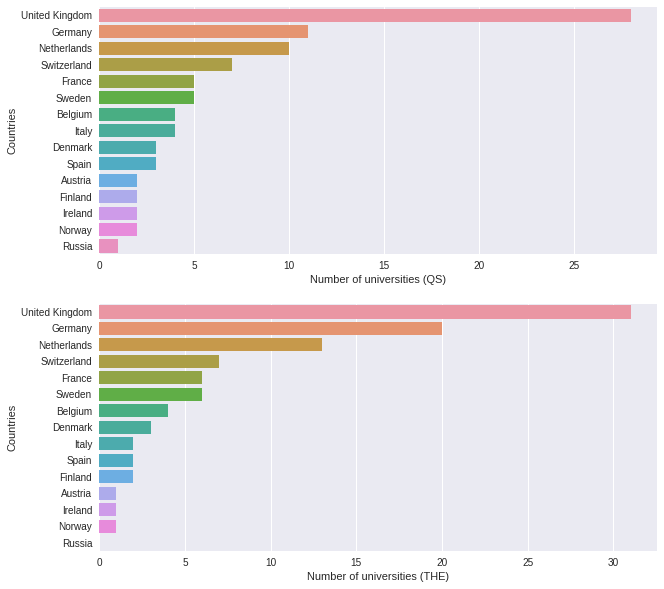

In [38]:
import seaborn as sns

# Computing the average rank in Europe and groupping by location
avg_rank_europe_qs = dataFrame_QS[dataFrame_QS.Region == 'Europe'].groupby('Location').agg({'Rank':'mean'}).sort_values(by='Rank', ascending=True)
avg_rank_europe_the = dataFrame_THE.groupby('Location').agg({'Rank':'mean'}).loc[avg_rank_europe_qs.index].sort_values(by='Rank', ascending=True)
avg_rank_europe_the.columns = ['Average Rank THE']
avg_rank_europe_qs.columns = ['Average Rank QS']
display(avg_rank_europe_qs)
display(avg_rank_europe_the)

# Get the count of universities per country in Europe for QS and THE
y_qs = dataFrame_QS[dataFrame_QS.Region == 'Europe'].groupby('Location').agg('count').sort_values(by='Rank', ascending=False)
y_the = dataFrame_THE.groupby('Location').agg('count').loc[y_qs.index].sort_values(by='Rank', ascending=False)

# Plot the number of universties against the Countries in Europe
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.barplot(y_qs['Rank'],y_qs.index, orient='h', ax=ax1)
ax1.set(xlabel='Number of universities (QS)', ylabel='Countries')
sns.barplot(y_the['Rank'],y_the.index, orient='h', ax=ax2)
ax2.set(xlabel='Number of universities (THE)', ylabel='Countries')
plt.show()

From above, we can see that UK universities are leading the European rankings given the number of universities and their average rank.

**How does the variables correlate in each ranking?**

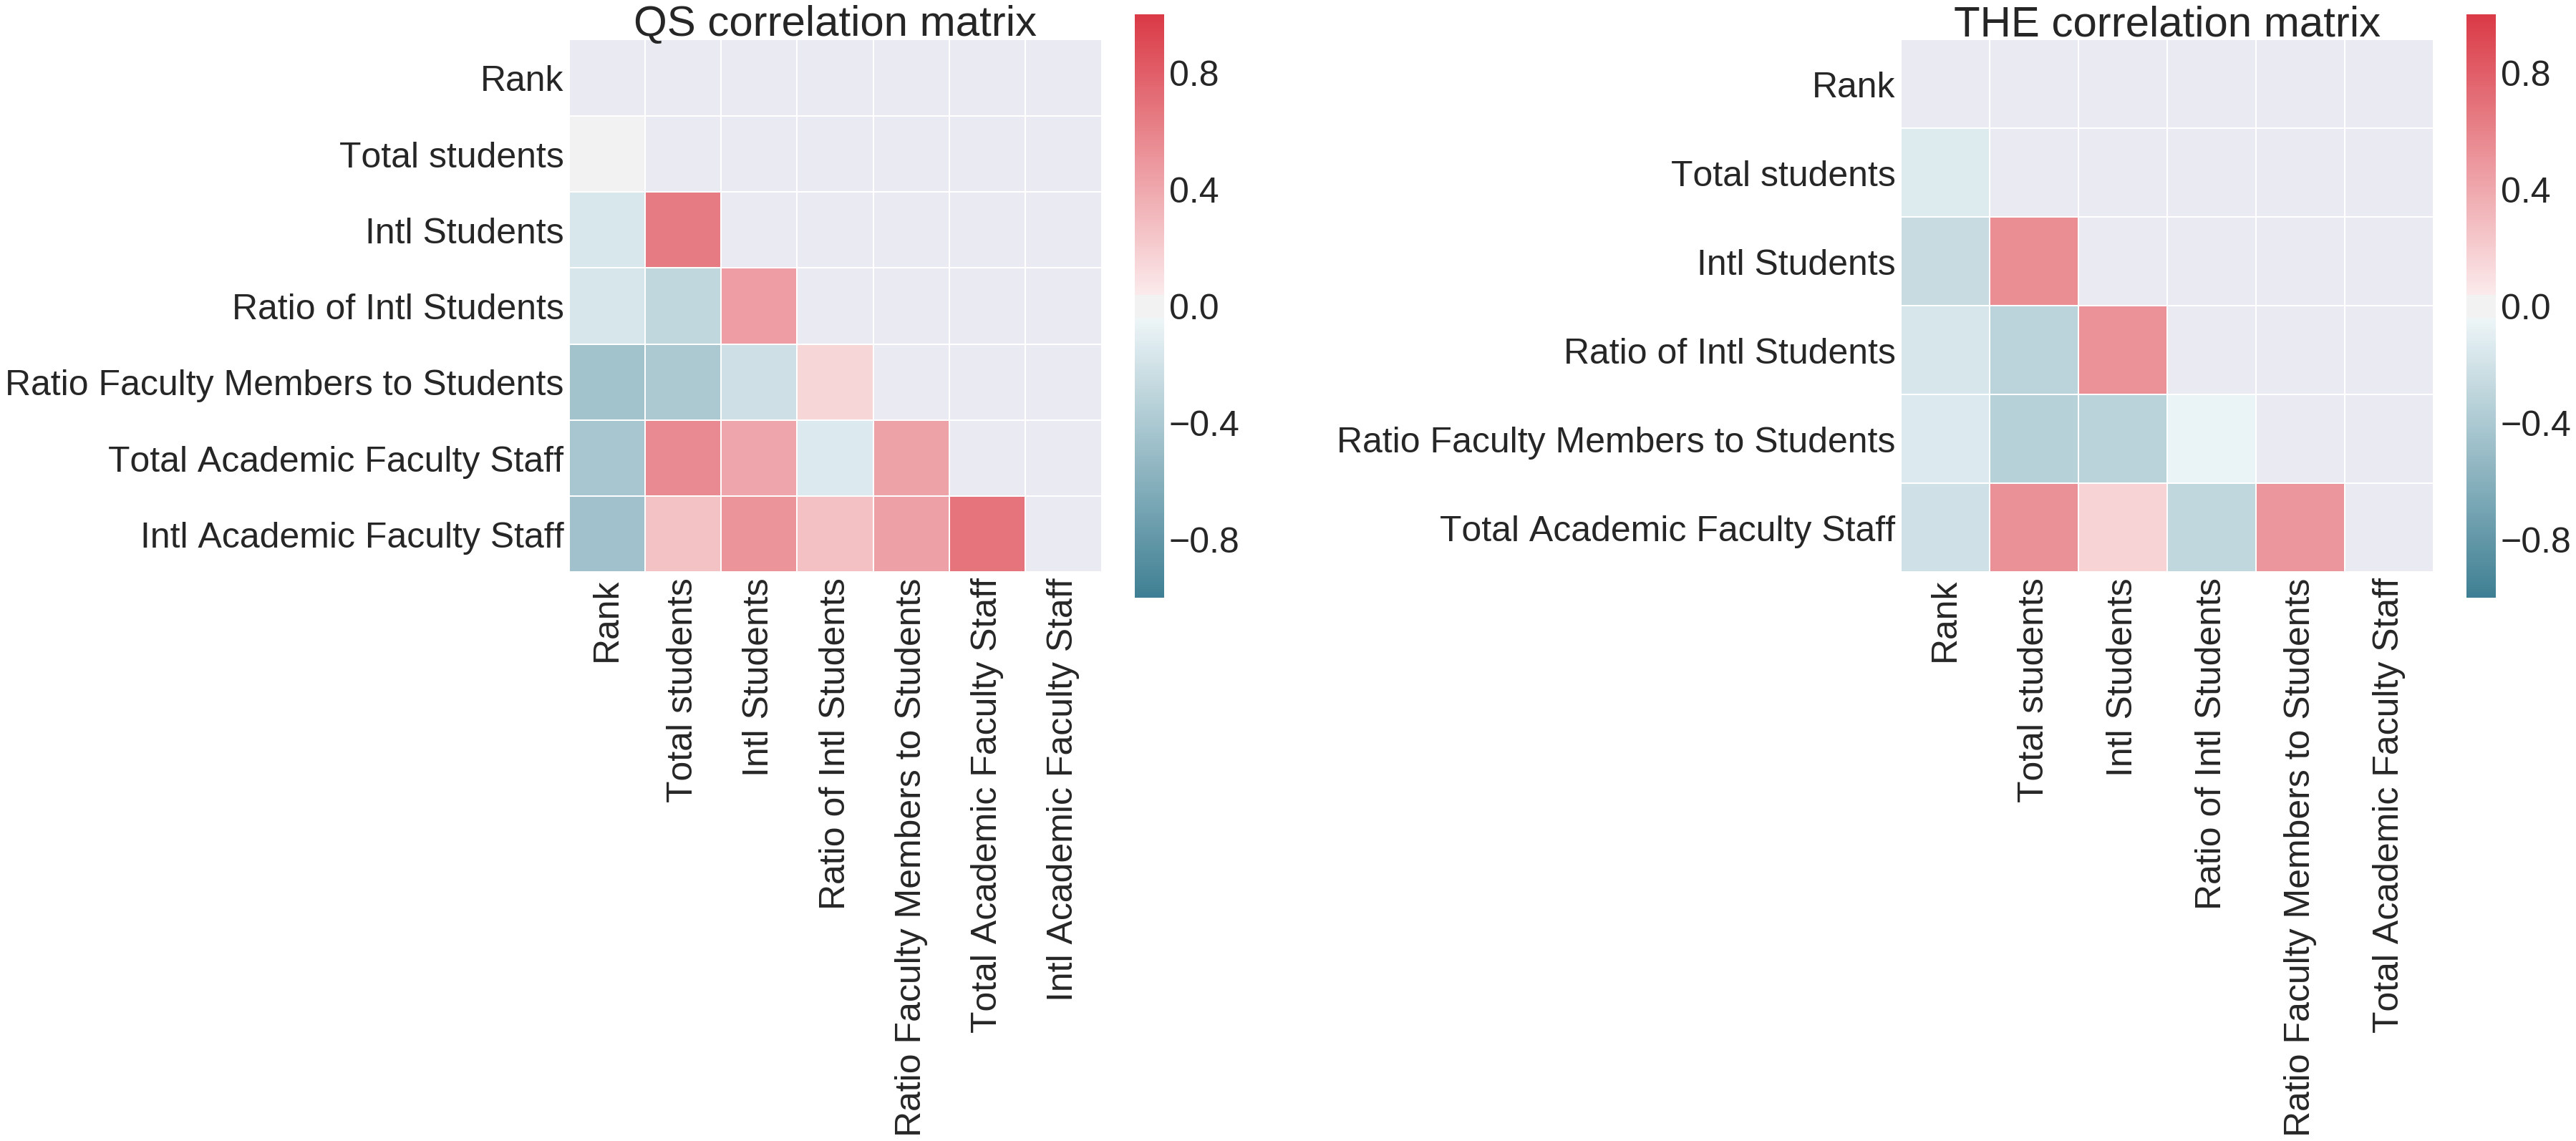

In [41]:
ordering = ['Rank','Total students','Intl Students','Ratio of Intl Students', 'Ratio Faculty Members to Students','Total Academic Faculty Staff','Intl Academic Faculty Staff']
corr_QS = dataFrame_QS.loc[mask_QS, ordering].corr()
corr_THE = dataFrame_THE.loc[mask_THE,ordering[:-1]].corr()

f,ax1 = plt.subplots(figsize=(50,50), nrows=1,ncols=2)
f.subplots_adjust(wspace=1)

sns.set(font_scale=5)
msk_QS = np.zeros_like(corr_QS, dtype=np.bool)
msk_QS[np.triu_indices_from(msk_QS)] = True
sns.heatmap(corr_QS, mask=msk_QS, linewidth=1, cbar_kws={'shrink':0.3}, cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax1[0])
ax1[0].set_title('QS correlation matrix')

msk_THE = np.zeros_like(corr_THE, dtype=np.bool)
msk_THE[np.triu_indices_from(msk_THE)] = True
sns.heatmap(corr_THE, mask=msk_THE, linewidth=1, cbar_kws={'shrink':0.3},cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax1[1])
ax1[1].set_title('THE correlation matrix')
plt.show()

**Observations:**

We observe that the following pair of variable present high correlation:
1. **Total Students / Intl Students** : This makes sense since the more international students there is, the bigger the total number of students is.

2. **Total Academic Faculty Staff / Total Students** : This correlation is obvious since the more student the university have, the more it will need academic faculty staff to teach courses and/or handle students' issues.

3. **Intl Academic Faculty Staff / Intl Students** (QS only): This correlation reinforce the international openness of universities.  The more international the faculty staff is the more attractive and open to internationals the university will be.

4. **Intl Academic Faculty Staff / Total Academic Faculty Staff** (QS only): Same reason as 1.

5. **Rank / Intl Academic Faculty Staff** (QS only): This can be due to the fact that universities with a high number of Intl Academic Faculty staff tends to be recruiting talents from all around the world. Hence having reputed international researchers  with an extensive experience can lead to the increase of the university ranking.

## 5-Determining the best university taking in consideration both rankings

Both QS and the Times Higher Education have an international, world ranking for universities, but they use different methodologies for creating them. This can drastically change the results since every ranking uses different weights for similar variables.

For [QS](https://www.topuniversities.com/university-rankings/world-university-rankings/2018) in the "Ranking Indicators", it seems that academic/employer reputation play crucial role in defining a university rank, meanwhile for [Times](https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/scores), it carries less weight and indicators such as industry income, international outlook and research productivity carry bigger weights.

From this brief comparaison, we can make the following conclusions :
Times table would be more suitable for people interested in universities that are innovative and multi-cultural, as well as prestigious.In the other hand, QS is for those who put reputation highly in their list of priorities.

As for our approach, we believe all aspects mentionned above should be taken into consideration to rank the universities, thus we weight both rankings equally to get the final list.
We assumed the THE and QS ranking value reflect precisely all the features mentionned above along with the variables we analysed before 

In [42]:
groupped_by_name['Rank'].sort_values(ascending=True)

Name
Stanford University                        2.5
Massachusetts Institute of Technology      3.0
University of Oxford                       3.5
California Institute of Technology         3.5
University of Cambridge                    3.5
                                         ...  
University of Liverpool                  175.0
Texas A&M University                     177.0
University of Twente                     179.0
University of Cape Town                  181.0
Scuola Normale Superiore di Pisa         188.0
Name: Rank, Length: 161, dtype: float64

The best university is Stanford.